<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/wganworkking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [269]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7,activation='LeakyReLU',use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(14*14,activation='LeakyReLU',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(28*28,activation='LeakyReLU',use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(28*28,activation='sigmoid',use_bias=False))
    model.add(layers.Reshape((28,28,1)))

    return model


def make_discriminator_model():
    input_img = layers.Input(shape=(28,28,1))

    x = layers.Conv2D(64,3,2,padding='same',activation='LeakyReLU')(input_img)

    x = layers.Dropout(.3)(x)

    x = layers.Conv2D(64,3,2,padding='same',activation='LeakyReLU')(x)

    x = layers.Dropout(.3)(x)

    x = layers.Flatten()(x)

    dense_output = layers.Dense(128, activation='LeakyReLU')(x)


    x = layers.Dropout(.3)(x)

    dense_output = layers.Dense(64, activation='LeakyReLU')(x)

    x = layers.Dropout(.3)(x)

    dense_output = layers.Dense(1, activation=None)(dense_output)

    model = tf.keras.models.Model(inputs=input_img, outputs=dense_output)
    return model



In [59]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [270]:
generator = make_generator_model()
discriminatorW = make_discriminator_model()
discriminatorU = make_discriminator_model()
generator_optimizer = tf.keras.optimizers.Adam(0.0004)
discriminatorW_optimizer = tf.keras.optimizers.Adam(0.0004)
discriminatorU_optimizer = tf.keras.optimizers.Adam(0.0004)

In [101]:
BATCH_SIZE = 10

#@tf.function
def discriminator_lossW(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    total_loss = fake_loss - real_loss
    return total_loss

#@tf.function
def generator_lossW(fake_output):
    return -tf.reduce_mean(fake_output)

#@tf.function
def gradient_penalty(real_images, fake_images):
    alpha = tf.random.uniform([BATCH_SIZE, 1, 1, 1], 0., 1.)
    real_images, fake_images = tf.cast(real_images, tf.float32), tf.cast(fake_images, tf.float32)
    interpolated_images = alpha * real_images + ((1 - alpha) * fake_images)
    with tf.GradientTape() as tape:
        tape.watch(interpolated_images)
        pred = discriminatorW(interpolated_images, training=True)
    gradients = tape.gradient(pred, [interpolated_images])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.)**2)
    return gp

In [259]:
NOISE_DIM = 100
GP_WEIGHT = 100


#@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    for i in range(5):
      with tf.GradientTape() as disc_tapeU:
        generated_images = generator(noise, training=True)

        real_outputU = discriminatorU(images, training=True)
        fake_outputU = discriminatorU(generated_images, training=True)
        disc_lossU = cross_entropy(tf.ones_like(real_outputU), real_outputU)




      gradients_of_discriminatorU = disc_tapeU.gradient(disc_lossU, discriminatorU.trainable_variables)
      discriminatorU_optimizer.apply_gradients(zip(gradients_of_discriminatorU, discriminatorU.trainable_variables))
      if i == 0:
        weights = discriminatorU.get_weights()


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tapeW:
        generated_images = generator(noise, training=True)

        real_outputW = discriminatorW(images, training=True)
        fake_outputW = discriminatorW(generated_images, training=True)
        real_outputU = discriminatorU(images, training=True)
        fake_outputU = discriminatorU(generated_images, training=True)
        disc_lossW = discriminator_lossW(real_outputW, fake_outputW)


        gen_lossU = cross_entropy(tf.ones_like(fake_outputU), fake_outputU)
        gen_lossW = generator_lossW(fake_outputW)
        gen_loss = gen_lossU+gen_lossW

        gp = gradient_penalty(images, generated_images)
        disc_lossW += gp * GP_WEIGHT



    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    gradients_of_discriminatorW = disc_tapeW.gradient(disc_lossW, discriminatorW.trainable_variables)
    discriminatorW_optimizer.apply_gradients(zip(gradients_of_discriminatorW, discriminatorW.trainable_variables))

    discriminatorU.set_weights(weights)

    tf.print("disc_lossW",disc_lossW,'disc_lossU',disc_lossU,'gen_lossU',gen_lossU,'gen_lossW',gen_lossW)

In [195]:
def train(dataset, epochs):
  for epoch in range(epochs):
    for batch in range(len(dataset) // BATCH_SIZE):

            target_images = dataset[batch * BATCH_SIZE: (batch+1) * BATCH_SIZE]


            train_step(target_images)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      print(epoch)



In [271]:
EPOCHS = 10
x_train2 = np.expand_dims(x_train, axis=-1)
x_train2 = (x_train2 - np.min(x_train2)) / (np.max(x_train2) - np.min(x_train2))
train(x_train2, EPOCHS)

disc_lossW 60.7172966 disc_lossU 0.452938259 gen_lossU 0.274308413 gen_lossW 0.0259488858
disc_lossW 56.642292 disc_lossU 0.403111875 gen_lossU 0.16581893 gen_lossW 0.0293054618
disc_lossW 54.6427765 disc_lossU 0.307659805 gen_lossU 0.0919928774 gen_lossW 0.152300537
disc_lossW 50.1189384 disc_lossU 0.256576687 gen_lossU 0.0341245234 gen_lossW 0.1446466
disc_lossW 46.3003693 disc_lossU 0.230242893 gen_lossU 0.0195491202 gen_lossW 0.228560761
disc_lossW 42.0719833 disc_lossU 0.129773229 gen_lossU 0.00593155902 gen_lossW 0.206511185
disc_lossW 36.874218 disc_lossU 0.111255862 gen_lossU 0.00178138562 gen_lossW 0.228810832
disc_lossW 32.385 disc_lossU 0.0773154944 gen_lossU 0.000628498557 gen_lossW 0.185133785
disc_lossW 26.9661484 disc_lossU 0.0469269641 gen_lossU 0.000285636459 gen_lossW 0.389571726
disc_lossW 23.7707176 disc_lossU 0.0426990502 gen_lossU 0.000120831872 gen_lossW 0.334014684
disc_lossW 17.2415142 disc_lossU 0.0511624441 gen_lossU 4.86359058e-05 gen_lossW 0.402810425
disc_

KeyboardInterrupt: ignored

1/1 [==============================] - 0s 16ms/step


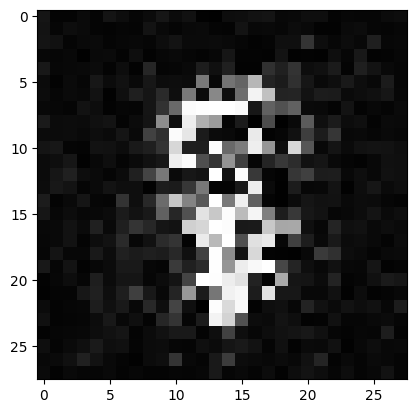

In [276]:
noise = tf.random.normal(shape=(1,100))
test = generator.predict(noise)
plt.imshow(test.squeeze(), cmap='gray')
plt.show()

In [ ]:
print(np.min(x_train2))